In [4]:
import pysam
import os
import glob
from genepeeks.common import utilities as util
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tabletext

INFO:config:Using ini file set by environment: /home/ec2-user/config/genepeeks.ini


#### Get DMD exons

In [44]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200)

Finished loading ensembl within the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 0.33 sec


### Get insert length data, broken down by exon

In [40]:
%%time
# bam_files_folder = '../../library_files/inputs/bam_files'
exon_insert_lengths = {}
subject_insert_lengths = {}
skipped_counts = {}
subject_count = 0
for root, dirs, files in os.walk('/mnt/vep/subjects'):
    if root.endswith('re86'):
        continue

    for file_name in files:
        if file_name.endswith('.bam'):
            if '{}.bai'.format(file_name) not in files:
                print '{} is missing an index file'.format(file_name)
                continue

            file_path = os.path.join(root, file_name)
            date_modified = os.path.getmtime(file_path)

            subject = (os.path.splitext(file_name)[0], date_modified)
            bamfile = pysam.AlignmentFile(file_path, "rb")
#             bwa_version = next(PG['VN'] for PG in bamfile.header['PG'] if PG.get('ID') == 'bwa')
#             if not bwa_version.startswith('0.7.15'):
#                 util.add_to_dict(skipped_counts, 'old_bwa_version')
#                 continue
            
            for read in bamfile.fetch('X', start=31137345, end=33229636):
                if read.is_read1 and not read.is_unmapped and read.mapping_quality == 60 and not read.mate_is_unmapped and read.is_proper_pair:
                    insert_length = read.template_length
                    if read.is_reverse == read.mate_is_reverse:
                        util.add_to_dict(skipped_counts, 'tandem_pair')
                        continue
                    elif read.is_reverse:
                        orientation = 'RF'
                        insert_length *= -1
                    else:
                        orientation = 'FR'

                    if insert_length < 0:
#                         print subject, read.template_length, read.reference_start, read.next_reference_start
                        util.add_to_dict(skipped_counts, 'negative_insert_length')
                        continue
        
                    pair_start = min(read.reference_start, read.next_reference_start)
                    pair_end = pair_start + insert_length
                    for i, exon in enumerate(DMD_exons_merged):
                        if exon['end'] < pair_start:
                            continue
                        else:
                            if exon['start'] > pair_end:
                                exon_num = None
                            else:
                                exon_num = i
                            break
                    if exon_num is None:
                        util.add_to_dict(skipped_counts, 'outside_of_exon')
                        continue

                    util.add_to_dict(exon_insert_lengths, exon_num, insert_length, keep_values=True)
                    util.add_to_dict(subject_insert_lengths, subject, insert_length, keep_values=True)
            subject_count += 1
            if subject_count % 10 == 0:
                print 'Finished parsing {} subjects'.format(subject_count)

# Print counts of skipped reads
for k, v in skipped_counts.items():
    print k, v

Finished parsing 10 subjects
Finished parsing 20 subjects
Finished parsing 30 subjects
Finished parsing 40 subjects
Finished parsing 50 subjects
Finished parsing 60 subjects
Finished parsing 70 subjects
Finished parsing 80 subjects
Finished parsing 90 subjects
Finished parsing 100 subjects
Finished parsing 110 subjects
Finished parsing 120 subjects
Finished parsing 130 subjects
Finished parsing 140 subjects
Finished parsing 150 subjects
FK2R-0000-151I.bam is missing an index file
Finished parsing 160 subjects
Finished parsing 170 subjects
Finished parsing 180 subjects
Finished parsing 190 subjects
Finished parsing 200 subjects
Finished parsing 210 subjects
Finished parsing 220 subjects
Finished parsing 230 subjects
Finished parsing 240 subjects
Finished parsing 250 subjects
Finished parsing 260 subjects
Finished parsing 270 subjects
Finished parsing 280 subjects
Finished parsing 290 subjects
Finished parsing 300 subjects
Finished parsing 310 subjects
Finished parsing 320 subjects
Finis

In [2]:
import pickle

with open('exon_insert_lengths.pickle', 'wb') as handle:
    pickle.dump(exon_insert_lengths, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('exon_insert_lengths.pickle', 'rb') as handle:
#     exon_insert_lengths = pickle.load(handle)

#### Get insert length stats for each exon

In [47]:
exon_outlier_marks = [['Exon', 'Read Count', '0.1% Cutoff', '99.9% Cutoff']]

exon_stats_dict = {}
for exon_index, insert_lengths in exon_insert_lengths.items():
    exon_upper = np.percentile(insert_lengths, 99.9)
    exon_lower = np.percentile(insert_lengths, 0.1)    
    if exon_index == 64:
        exon = '65/66'
    elif exon_index > 64:
        exon = exon_index + 2
    else:
        exon = exon_index + 1
    exon_outlier_marks.append([exon, len(insert_lengths), exon_lower, exon_upper])
    exon_stats_dict[exon_index] = [exon_lower, exon_upper]
    
#     clipped_exon_insert_lengths = [item for item in insert_lengths if 0 < item < 800]
#     plt.hist(clipped_exon_insert_lengths)
#     plt.title("Exon {} ({} reads)".format(exon, len(clipped_exon_insert_lengths)))
#     plt.xlabel("Insert Length")
#     plt.ylabel("Count")
#     plt.show()
print tabletext.to_text(exon_outlier_marks)

┌───────┬────────────┬─────────────┬──────────────┐
│ Exon  │ Read Count │ 0.1% Cutoff │ 99.9% Cutoff │
├───────┼────────────┼─────────────┼──────────────┤
│     1 │     206022 │        47.0 │        686.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     2 │      32373 │        53.0 │      682.256 │
├───────┼────────────┼─────────────┼──────────────┤
│     3 │      78665 │        45.0 │        698.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     4 │     120276 │      48.275 │        672.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     5 │      54335 │        47.0 │      679.332 │
├───────┼────────────┼─────────────┼──────────────┤
│     6 │      89717 │        48.0 │        681.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     7 │     138561 │        58.0 │        682.0 │
├───────┼────────────┼─────────────┼──────────────┤
│     8 │     102512 │        47.0 │      678.489 │
├───────┼────────────┼─────────────┼──────────────┤
│     9 │   

#### Create table of quartile insert lengths for each subject

In [41]:
wanted_percentiles = [5, 25, 50, 75, 95]
headers = ['Subject', 'Date_modified'] + ['{}%'.format(perc) for perc in wanted_percentiles]
subject_insert_length_table = [headers]
for subject, insert_lengths in subject_insert_lengths.iteritems():
    subject_stats = [np.percentile(insert_lengths, perc) for perc in wanted_percentiles]
    subject_insert_length_table.append(list(subject) + subject_stats)
print subject_insert_length_table

[['Subject', 'Date_modified', '5%', '25%', '50%', '75%', '95%'], ['MMCB-0000-1301', 1465400164.0, 148.0, 233.0, 331.0, 434.0, 585.0], ['FPWB-0001-0309', 1466796480.0, 193.60000000000002, 213.5, 225.0, 411.5, 509.59999999999991], ['MMCB-0000-150Z', 1465400434.0, 89.0, 156.0, 254.0, 295.0, 369.0], ['MMCB-0000-126Q', 1465400922.0, 82.0, 140.0, 192.0, 239.0, 340.0], ['FCLR-GP17-435H', 1477957947.0, 125.0, 176.0, 220.0, 275.0, 361.0], ['FPWB-0001-1612', 1466795573.0, 134.0, 195.0, 257.0, 342.0, 484.0], ['MESB-0008-712Q', 1465400171.0, 65.0, 121.0, 202.5, 293.0, 363.0], ['MMCB-0000-137N', 1465401028.0, 84.0, 147.0, 201.0, 252.0, 348.0], ['MCLR-CD00-0262', 1465397183.0, 180.0, 253.0, 322.0, 407.0, 542.0], ['MMCB-0000-117P', 1465400709.0, 142.0, 221.75, 306.0, 398.0, 536.0], ['MESB-0009-662M', 1465401003.0, 47.0, 68.0, 96.0, 128.0, 181.0], ['FPWB-0000-731U', 1465393832.0, 138.0, 208.0, 278.0, 375.0, 554.0], ['MMCB-0000-273P', 1465400591.0, 128.0, 193.0, 219.0, 258.0, 336.0], ['FGPC-0000-5279',

In [43]:
import pandas as pd

df = pd.DataFrame(subject_insert_length_table)
df.to_csv("../exon_data/subject_insert_lengths.csv")

#### Plot a histogram of all insert lengths across all exons

704.0 47.0


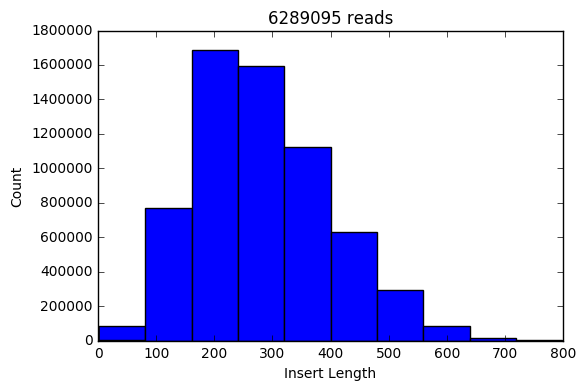

In [33]:
all_insert_lengths = list(itertools.chain(*exon_insert_lengths.values()))
print np.percentile(all_insert_lengths, 99.9), np.percentile(all_insert_lengths, 0.1)
# print np.percentile(all_insert_lengths, 0.1)
clipped_insert_lengths = [item for item in all_insert_lengths if 0 < item < 800]
bad_insert_lengths = [item for item in all_insert_lengths if item < 0 or item > 800]
# print len(bad_insert_lengths)

# Plot a histogram of distribution of insert lengths across all exons for each orientation
plt.hist(clipped_insert_lengths)
plt.title("{} reads".format(len(clipped_insert_lengths)))
plt.xlabel("Insert Length")
plt.ylabel("Count")
plt.show()

#### Check for any subject with multiple anomalous insert lengths in any exon

In [45]:
%%time
count = 0
all_subjects = {}
for root, dirs, files in os.walk('/mnt/vep/subjects'):
    for file_name in files:
        if file_name.endswith('.bam'):# and file_name == 'MMCB-0000-144S.bam':
            if '{}.bai'.format(file_name) not in files:
                print '{} is missing an index file'.format(file_name)
                continue

            file_path = os.path.join(root, file_name)
            subject = os.path.splitext(file_name)[0]
            subject_outliers = {}
            bamfile = pysam.AlignmentFile(file_path, "rb")
            for read in bamfile.fetch('X', start=31137345, end=33229636):
                if read.is_read1 and not read.is_unmapped and read.mapping_quality == 60 and not read.mate_is_unmapped and read.is_proper_pair:
                    insert_length = read.template_length
                    if read.is_reverse == read.mate_is_reverse:
                        util.add_to_dict(skipped_counts, 'tandem_pair')
                        continue
                    elif read.is_reverse:
                        orientation = 'RF'
                        insert_length *= -1
                    else:
                        orientation = 'FR'

                    if insert_length < 0:
#                         print subject, read.template_length, read.reference_start, read.next_reference_start
                        util.add_to_dict(skipped_counts, 'negative_insert_length')
                        continue
        
                    pair_start = min(read.reference_start, read.next_reference_start)
                    pair_end = pair_start + insert_length
                    for i, exon in enumerate(DMD_exons_merged):
                        if exon['end'] < pair_start:
                            continue
                        else:
                            if exon['start'] > pair_end:
                                exon_num = None
                            else:
                                exon_num = i
                            break
                    if exon_num is None:
                        util.add_to_dict(skipped_counts, 'outside_of_exon')
                        continue
                        
                    util.add_to_dict(subject_outliers, exon_num, nested_key='total')
                    if insert_length > exon_stats_dict[exon_num][1]:
                        util.add_to_dict(subject_outliers[exon_num], 'large')
                    elif insert_length < exon_stats_dict[exon_num][0]:
                        util.add_to_dict(subject_outliers[exon_num], 'small')
#                         print orientation, exon_num, in_exon, exon_stats_dict[exon_num], insert_length, read.reference_length

            all_subjects[subject] = subject_outliers
            count += 1
            if count % 10 == 0:
                print 'Finished parsing {} subjects'.format(count)

Finished parsing 10 subjects
Finished parsing 20 subjects
Finished parsing 30 subjects
Finished parsing 40 subjects
Finished parsing 50 subjects
Finished parsing 60 subjects
Finished parsing 70 subjects
Finished parsing 80 subjects
Finished parsing 90 subjects
Finished parsing 100 subjects
Finished parsing 110 subjects
Finished parsing 120 subjects
Finished parsing 130 subjects
Finished parsing 140 subjects
Finished parsing 150 subjects
Finished parsing 160 subjects
FK2R-0000-151I.bam is missing an index file
Finished parsing 170 subjects
Finished parsing 180 subjects
Finished parsing 190 subjects
Finished parsing 200 subjects
Finished parsing 210 subjects
Finished parsing 220 subjects
Finished parsing 230 subjects
Finished parsing 240 subjects
Finished parsing 250 subjects
Finished parsing 260 subjects
Finished parsing 270 subjects
Finished parsing 280 subjects
Finished parsing 290 subjects
Finished parsing 300 subjects
Finished parsing 310 subjects
Finished parsing 320 subjects
Finis

#### Create contingency table for each subject's number of insert lengths beyond the expected length for each exon

In [49]:
headers = ['Subject']
for exon_index in range(len(DMD_exons_merged)):
    if exon_index == 64:
        exon = '65/66'
    elif exon_index > 64:
        exon = exon_index + 2
    else:
        exon = exon_index + 1
    headers += ['Ex{}_total'.format(exon), 'Ex{}_low'.format(exon), 'Ex{}_high'.format(exon)]

contingency_table = [headers]
for subject, subject_outliers in all_subjects.items():
    exon_array = [subject]
    for i in range(len(DMD_exons_merged)):
        exon_outliers = subject_outliers.get(i, {})
        exon_array += [exon_outliers.get('total', 0), exon_outliers.get('small', 0), exon_outliers.get('large', 0)]
#         if exon_outliers.get('small', 0) > 10 or exon_outliers.get('large', 0) > 10:
#             print subject, i, exon_outliers
    contingency_table.append(exon_array)
contingency_table = np.array(contingency_table)
print contingency_table

[['Subject' 'Ex1_total' 'Ex1_low' ..., 'Ex79_total' 'Ex79_low' 'Ex79_high']
 ['MCLR-NA03-037C' '78' '0' ..., '40' '0' '0']
 ['FGPC-JFHQ-PS5C' '1075' '1' ..., '313' '0' '0']
 ..., 
 ['MCLR-GP04-8630' '151' '0' ..., '48' '0' '0']
 ['MMCB-0007-5782' '64' '0' ..., '31' '0' '0']
 ['FGPC-0000-6079' '1244' '0' ..., '302' '0' '0']]


In [24]:
import pandas as pd

df = pd.DataFrame(contingency_table)
df.to_csv("../exon_data/PEM_contingency_table.csv")